## Note: Increased IOPub
For visualization, if you did not start this notebook with an increased data rate limit, stop the notebook, go back to the command line, and start Jupyter Notebook using the following command.

`jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000000`

# Import the Python API module and Instantiate the GIS object

Import the Python API

In [1]:
import arcgis
from getpass import getpass

Create an GIS object instance using the [account currently logged in through ArcGIS Pro](https://developers.arcgis.com/python/guide/working-with-different-authentication-schemes/#ArcGIS-Pro-user-connecting-to-the-active-portal-in-the-Pro-app)

In [2]:
#gis_retail = arcgis.gis.GIS('Pro')  # optional, use if can use ArcGIS Pro authentication
gis_retail = arcgis.gis.GIS(
    username='jmccune_retail',  # change this to your username 
    password=getpass('Please enter your password: ')
)

Please enter your password: ········


# Get a Data Frame, data to work with, from the Web GIS Item ID

Create a [Web GIS Item](http://esri.github.io/arcgis-python-api/apidoc/html/arcgis.gis.toc.html#item) instance using the Item ID

In [3]:
trade_area_itemid = '44c0b666404c41b8a14e04c34d09be1e'
item = arcgis.gis.Item(gis=gis_retail, itemid=trade_area_itemid)
item

<Item title:"targetWithDemographics" type:Feature Layer Collection owner:joel5174@esri.com_commteamretail>

Since the item only contains one feature layer, get the first layer in the item, the [Feature Layer](http://esri.github.io/arcgis-python-api/apidoc/html/arcgis.features.toc.html#featurelayer) we need to work with.

In [4]:
feature_layer = item.layers[0]
feature_layer

<FeatureLayer url:"https://services.arcgis.com/PMTtzuTB6WiPuNSv/arcgis/rest/services/targetWithDemographics/FeatureServer/0">

Use [query](http://esri.github.io/arcgis-python-api/apidoc/html/arcgis.features.toc.html#arcgis.features.FeatureLayer.query) to return the data as a [Feature Set](http://esri.github.io/arcgis-python-api/apidoc/html/arcgis.features.toc.html#featureset).

In [5]:
feature_set = feature_layer.query()

Take advantage of the [`df` function](http://esri.github.io/arcgis-python-api/apidoc/html/arcgis.features.toc.html#arcgis.features.FeatureSet.df) on the Feature set object returned from the query to convert the data to a [Pandas Data Frame](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html).

In [6]:
df = feature_set.df
df.head()

,OBJECTID,Target_Locations_CITY,Target_Locations_CONAME,Target_Locations_LOCNUM,Target_Locations_NAICS,Target_Locations_SALESVOL,Target_Locations_SIC,Target_Locations_SQFTCODE,Target_Locations_STATE,Target_Locations_STREET,...,overlayTemplate_VAL200K_CY,overlayTemplate_VAL250K_CY,overlayTemplate_VAL300K_CY,overlayTemplate_VAL400K_CY,overlayTemplate_VAL500K_CY,overlayTemplate_VAL50K_CY,overlayTemplate_VAL750K_CY,overlayTemplate_WHITE_CY,overlayTemplate_WIDOWED_CY,SHAPE
0,1,SEASIDE,TARGET,666990510,45211101,35495,531102,D,CA,CALIFORNIA AVE,...,200,354,934,693,1976,81,1012,23576,1902,"{'y': 4386409.918831829, 'x': -13563500.716724..."
1,2,MARINA,TARGET,653371815,45211101,35495,531102,D,CA,GENERAL STILLWELL DR,...,137,270,1043,742,1612,81,588,21068,1500,"{'y': 4392875.237199519, 'x': -13559960.756917..."
2,3,CAPITOLA,TARGET,423468472,45211101,35495,531102,D,CA,41ST AVE,...,372,405,1015,1271,4018,261,2452,41050,2524,"{'y': 4435664.48477165, 'x': -13577092.826550681}"
3,4,WATSONVILLE,TARGET,511743478,45211101,35495,531102,D,CA,MAIN ST,...,456,449,870,982,1211,197,293,19905,1323,"{'y': 4427321.189443219, 'x': -13555819.671860..."
4,5,CUPERTINO,TARGET,404459478,45211101,52059,531102,D,CA,STEVENS CREEK BLVD,...,43,49,211,519,2823,110,7694,41689,5226,"{'y': 4484238.960603427, 'x': -13585007.642346..."


Because I am neurotic, and hate the prefixes added to the field names from the join when preparing the data in ArcMap, we are cleaning them up a little here.

In [7]:
df.columns = [field.replace('Target_Locations_', '').replace('overlayTemplate_', '') for field in df.columns]
df.head()

,OBJECTID,CITY,CONAME,LOCNUM,NAICS,SALESVOL,SIC,SQFTCODE,STATE,STREET,...,VAL200K_CY,VAL250K_CY,VAL300K_CY,VAL400K_CY,VAL500K_CY,VAL50K_CY,VAL750K_CY,WHITE_CY,WIDOWED_CY,SHAPE
0,1,SEASIDE,TARGET,666990510,45211101,35495,531102,D,CA,CALIFORNIA AVE,...,200,354,934,693,1976,81,1012,23576,1902,"{'y': 4386409.918831829, 'x': -13563500.716724..."
1,2,MARINA,TARGET,653371815,45211101,35495,531102,D,CA,GENERAL STILLWELL DR,...,137,270,1043,742,1612,81,588,21068,1500,"{'y': 4392875.237199519, 'x': -13559960.756917..."
2,3,CAPITOLA,TARGET,423468472,45211101,35495,531102,D,CA,41ST AVE,...,372,405,1015,1271,4018,261,2452,41050,2524,"{'y': 4435664.48477165, 'x': -13577092.826550681}"
3,4,WATSONVILLE,TARGET,511743478,45211101,35495,531102,D,CA,MAIN ST,...,456,449,870,982,1211,197,293,19905,1323,"{'y': 4427321.189443219, 'x': -13555819.671860..."
4,5,CUPERTINO,TARGET,404459478,45211101,52059,531102,D,CA,STEVENS CREEK BLVD,...,43,49,211,519,2823,110,7694,41689,5226,"{'y': 4484238.960603427, 'x': -13585007.642346..."


# Store Segmentation Using KMeans Clustering

Use KMeans cluster analysis from the Sci-Kit Learn package to segment the demographically similar stores together.

In [21]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np

%matplotlib inline

Create the KMeans clusterer, specifying it to create five clusters, or segments.

In [22]:
km = KMeans(n_clusters=5)

Use the `fit_predict` method to create the clusters using just the numeric fields - not including the OID and sales fields.

In [23]:
df_independent = df.select_dtypes(include=[np.number]).drop(['OBJECTID', 'SALESVOL'], axis=1)
fields_independent = df_independent.columns  # save for later
field_name_dependent = 'SALESVOL' # keep track of this as well

In [24]:
df['segment'] = km.fit_predict(df.select_dtypes(include=[np.number]).drop(['OBJECTID', 'SALESVOL'], axis=1))

# Investigate the Results

Now, take a look at a few descriptive metrics to begin to understand the results - initially by creating a data frame with the segments, mean sales for each segment, median sales for each segment, and the median sales for each segment.

In [25]:
df_count = df.segment.value_counts().reset_index().rename(columns={'index': 'segment', 'segment': 'count'})
df_mean = df.groupby('segment').mean()[field_name_dependent].reset_index().rename(
    columns={'segment': 'segment', field_name_dependent: 'mean_sales'})
df_median = df.groupby('segment').median()[field_name_dependent].reset_index().rename(
    columns={'segment': 'segment', field_name_dependent: 'median_sales'})

In [26]:
df_summary = pd.merge(df_count, df_mean)
df_summary = pd.merge(df_summary, df_median)
df_summary = df_summary.sort_values('mean_sales', ascending=False)
df_summary['mean_sales_zscore'] = df_summary.apply(lambda row: (row.mean_sales - df.SALESVOL.mean()) / df.SALESVOL.std(ddof=0), axis=1)
print('Sales Mean: {:.2f}\nSales Standard Deviation: {:.2f}'.format(df.SALESVOL.mean(), df.SALESVOL.std()))
df_summary

Sales Mean: 35147.10
Sales Standard Deviation: 17891.99


,segment,count,mean_sales,median_sales,mean_sales_zscore
4,3,60,45022.900000,43313.5,0.552121
3,0,206,40630.970874,35495.0,0.306584
2,2,358,38072.988827,35495.0,0.163576
1,4,534,34568.792135,33751.0,-0.032331
0,1,650,31361.126154,32268.0,-0.211660


Now, using data from this data frame, visualize the means of each segment against the mean, and one-half standard deviation above and below the mean.

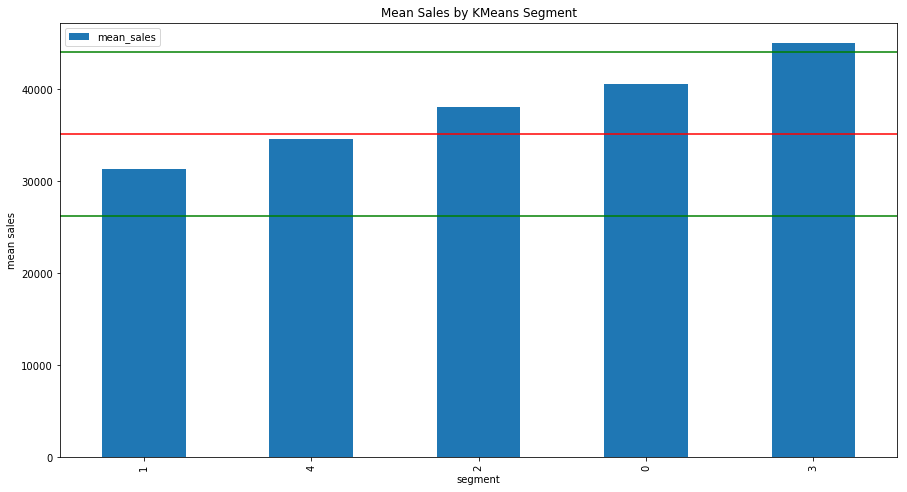

In [27]:
ax = df_summary.sort_values('mean_sales').plot.bar(y='mean_sales', x='segment', figsize=(15, 8))
ax.set_ylabel('mean sales')
ax.set_title('Mean Sales by KMeans Segment')

ax.axhline(y=df.SALESVOL.mean(), color='r') # add the mean for reference
ax.axhline(y=df.SALESVOL.mean() - df.SALESVOL.std() * 0.5, color='g')
ax.axhline(y=df.SALESVOL.mean() + df.SALESVOL.std() * 0.5, color='g')

Get a data frame of the respective segment feature coefficients.

# Map Results

For mapping, for the sake of discussion, we are focusing on the top performing stores - the 51 stores in the top segment.

In [28]:
top_segment = df_summary.iloc[0].segment
top_segment

3.0

In [29]:
df_top_performing = df[df.segment == top_segment]
df_top_performing.head()

,OBJECTID,CITY,CONAME,LOCNUM,NAICS,SALESVOL,SIC,SQFTCODE,STATE,STREET,...,VAL250K_CY,VAL300K_CY,VAL400K_CY,VAL500K_CY,VAL50K_CY,VAL750K_CY,WHITE_CY,WIDOWED_CY,SHAPE,segment
4,5,CUPERTINO,TARGET,404459478,45211101,52059,531102,D,CA,STEVENS CREEK BLVD,...,49,211,519,2823,110,7694,41689,5226,"{'y': 4484238.960603427, 'x': -13585007.642346...",3
5,6,SAN JOSE,TARGET,373128867,45211101,84715,531102,D,CA,SARATOGA AVE,...,84,408,1002,7996,136,10636,70131,6289,"{'y': 4479998.294713166, 'x': -13579942.605514...",3
6,7,SUNNYVALE,TARGET,402344537,45211101,35495,531102,D,CA,W MC KINLEY AVE,...,179,874,1620,6575,351,7622,54321,4554,"{'y': 4491324.546614874, 'x': -13584573.496331...",3
7,8,SAN JOSE,TARGET,637354200,45211101,35495,531102,D,CA,BLOSSOM HILL RD,...,730,2347,4110,16914,847,8664,95636,6032,"{'y': 4474081.01258884, 'x': -13565548.995355422}",3
9,10,SAN JOSE,TARGET,230021602,45211101,70990,531102,D,CA,HILLSDALE AVE,...,310,994,2572,15838,284,11823,105854,6740,"{'y': 4475857.246924702, 'x': -13571860.810483...",3


I am trying to visualize the data results using two methods. First is creating a map widget, creating a feauture set from the data frame, and adding the feature set to the map widget. Second is using the plot method of the data frame to create the map widget with the data. Incidentally, neither actually works - so I am really confused.

In [30]:
# create a map widget
store_map = gis_retail.map('USA')

In [31]:
# create a feature set from the data frame
top_performing_feature_set = arcgis.features.FeatureSet.from_dataframe(df_top_performing)

In [32]:
# draw the features on the map
store_map.draw(top_performing_feature_set, symbol={"type": "esriSMS","style": "esriSMSCircle", "size": 8})

In [33]:
# switch to the light gray basemap and show the map
store_map.basemap = 'gray'
store_map

In [34]:
# use the plot method and see what happens...nothing...wonderful
alt_map = df_top_performing.plot()
alt_map.basemap = 'gray'
alt_map

# PCA

In [40]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [41]:
pca = PCA(n_components=2)

In [42]:
df['x'] = pca.fit_transform(df[fields_independent])[:,0]

In [43]:
df['y'] = pca.fit_transform(df[fields_independent])[:,1]

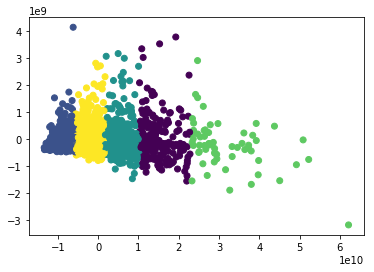

In [44]:
ax = plt.scatter(data=df, x='x', y='y', c='segment')
plt.show()